In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read dataset
input_address = 'D:/My Job/DataMining/Session4/Python'
file_name = 'data_dum.xlsx'
df_orig = pd.read_excel(input_address + '/' + file_name,index_col=0)

In [4]:
#make even the good and bad 

df_orig = df_orig.sort_values(by=['GOOD'], ascending=False)
df = df_orig[4842:]
weighted_good = len(df_orig)/len(df_orig[4842:])

In [5]:
df.columns

Index(['Obs', 'AGEAVG', 'TOTBAL', 'HSATRT', 'CURSAT', 'BRTRDS', 'BROPEN',
       'BROLDT', 'BRHS2X', 'BRHS3X', 'BRHS4X', 'BRHS5X', 'AUUTIL', 'CFTRDS',
       'INQ012', 'PUBREC', 'BKTIME', 'CBTYPE', 'ACCTNO', 'VAGE', 'VRESMOS',
       'VDDASAV', 'BAD', 'GOOD', 'TERM', 'DWNPMT', 'NTTRIN', 'BSWHOL',
       'BSRETL', 'MAKE', 'MODEL', 'NEWUSE', 'MNGPAY', 'CONTPR', 'RVOLDT',
       'TROP24', 'OREVTR', 'RVTRDS', 'ORVTB0', 'HST79X', 'TIME29', 'TIME39',
       'TIME49', 'CSORAT', 'T2924X', 'T3924X', 'T4924X', 'BRBAL1', 'REHSAT',
       'BKRETL', 'MODLYR', 'AGEOTD1', 'AGEOTD2', 'AGEOTD3', 'AGEOTD4',
       'HST03X1', 'HST03X2', 'HST03X3', 'MILEAG1', 'MILEAG2', 'MILEAG3',
       'MILEAG4', 'MILEAG5', 'VJOBMOS1', 'VJOBMOS2', 'VJOBMOS3'],
      dtype='object')

In [6]:
# pred_prob = model.predict_proba(X_test1)
# pred = model.predict(X_test1)
X=df[['AGEOTD1', 'AGEOTD2', 'AGEOTD3', 'AGEOTD4',
       'HST03X1', 'HST03X2', 'HST03X3', 'MILEAG1', 'MILEAG2', 'MILEAG3',
       'MILEAG4', 'MILEAG5', 'VJOBMOS1', 'VJOBMOS2', 'VJOBMOS3']]
y=df['GOOD']

model_ols = ols('GOOD~AGEOTD1+AGEOTD2+AGEOTD3+AGEOTD4+HST03X1+HST03X2+\
HST03X3+MILEAG1+MILEAG2+MILEAG3+MILEAG4+MILEAG5+VJOBMOS1+VJOBMOS2+VJOBMOS3',data=df).fit()

sigmoid_model = LogisticRegression().fit(X,y)

In [7]:
print(model_ols.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.032     
Dependent Variable: GOOD             AIC:                13071.9646
Date:               2020-05-11 09:58 BIC:                13185.9959
No. Observations:   9200             Log-Likelihood:     -6520.0   
Df Model:           15               F-statistic:        21.30     
Df Residuals:       9184             Prob (F-statistic): 6.01e-58  
R-squared:          0.034            Scale:              0.24202   
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
Intercept    0.4898     0.0124   39.4093   0.0000    0.4654    0.5141
AGEOTD1      0.0356     0.0166    2.1415   0.0323    0.0030    0.0682
AGEOTD2      0.0678     0.0240    2.8247   0.0047    0.0207    0.1148
AGEOTD3      0.0815     0.0237    3.4433   0.0006    0

In [8]:
pred_ols = model_ols.predict(df)
pred_sigmoid = sigmoid_model.predict_proba(X)
pred_sigmoid_class = sigmoid_model.predict(X)
pred_sigmoid = pred_sigmoid[:,1] #probability to be in 'GOOD' category

In [9]:
df['OLS_PRED'] = pred_ols
df['sigmoid_prob_PRED'] = pred_sigmoid
df['sigmoid_class_PRED'] = pred_sigmoid_class

In [10]:
#convert probability to 0 and 1 by cutoff
def class_pred(pred,cut_off):
    class_prediction=[]
    for i in pred:
        if i>=cut_off:
            class_prediction.append(1)
        else:
            class_prediction.append(0)
    return class_prediction
            

In [11]:
#Add the ols class-prediction to datafram
pred_ols_class=class_pred(df['OLS_PRED'],0.5)
df['ols_class_pred'] = pred_ols_class

In [12]:
#models evaluating
ols_conf_matrix = confusion_matrix(df['GOOD'],df['ols_class_pred'])
sigmoid_conf_matrix = confusion_matrix(df['GOOD'],df['sigmoid_class_PRED'])
print(f"Confusion matric of OLS\n{ols_conf_matrix}\
\n\nConfusion matric of Sigmoid\n{sigmoid_conf_matrix}")

Confusion matric of OLS
[[2810 1790]
 [2092 2508]]

Confusion matric of Sigmoid
[[2832 1768]
 [2116 2484]]


In [13]:
#Frequency table of GOOD and BAD based on probability of model

prediction_probability = df['OLS_PRED']

##Cross tab is the frequency of good and bad for each predicted value from our model

cross_tab = pd.crosstab(index=prediction_probability,
                        columns=df['GOOD'])# colnames=['GOOD'],margins=True,margins_name='TOTAL')    

In [36]:
cross_tab.head()

GOOD,0,1
OLS_PRED,,
0.326783,163,72
0.350781,293,167
0.351166,17,10
0.362413,13,5
0.375164,34,23


In [120]:
##K-S Table and curve

def ks_table(cross_tab=cross_tab,weighted_good=2,weighted_bad=1):
    i=1000
    score_series=[]
    cum_score=[]
    index = []
    while i >0:
        i = i-50
        index.append(f"{i} to {i+50}")
        bound = cross_tab[(cross_tab.index<i/1000) & (cross_tab.index>(i-50)/1000)]

        score_series.append(bound.values)

    for i in range(len(score_series)):
        if score_series[i].shape[0]==0:
            cum_score.append([0,0])
        else:
            cum_score.append(score_series[i].cumsum(0)[-1])
    cum_score = np.asmatrix(cum_score)     
    ks=pd.DataFrame(cum_score,columns=['BAD','GOOD'],index=index)

    
    ks[['Cumulative_BAD','Cumulative_GOOD']]=ks.cumsum(0)
    
    ks[['Cumulative_Percentage_BAD','Cumulative_Percentage_GOOD']]=\
    ks[['Cumulative_BAD','Cumulative_GOOD']]/(ks[['Cumulative_BAD','Cumulative_GOOD']].max())
    
    ks['Difference'] = ks['Cumulative_Percentage_GOOD']-ks['Cumulative_Percentage_BAD']
    suggesting_cut_off = ks['Difference'].max()
    
    ks[['Cumulative_Population_BAD(weighted)','Cumulative__Population_GOOD(weighted)']]=\
    ks[['Cumulative_BAD','Cumulative_GOOD']]*[weighted_bad,weighted_good]
    
    ks['Accepted_Cumulated'] = ks['Cumulative_Population_BAD(weighted)']+ks['Cumulative__Population_GOOD(weighted)']
    
    ks['Acceptance_Percentage_Cumulative(%)']=((ks['Accepted_Cumulated']/ks['Accepted_Cumulated'].max())*100).round(2)
    
    ks['Cumulative_Bad_Rate(%)'] =((ks['Cumulative_Population_BAD(weighted)']/(ks['Cumulative_Population_BAD(weighted)']+ks['Cumulative__Population_GOOD(weighted)']))*100).round(2)
    
    print(f"{np.argmax(ks['Difference'])} is the suggested cutoff")
    
    plt.figure(figsize=(20,10))
    plt.plot(ks['Cumulative_Percentage_BAD'],'r-o',label='BAD')
    plt.plot(ks['Cumulative_Percentage_GOOD'],'b-o',label='GOOD')
    plt.ylabel('Cumulative Percentage',fontsize=20)
    plt.xlabel('Score Cutoff' , fontsize=20)
    plt.title('K-S Test',fontsize=22)
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return(ks);
    


550 to 600 is the suggested cutoff


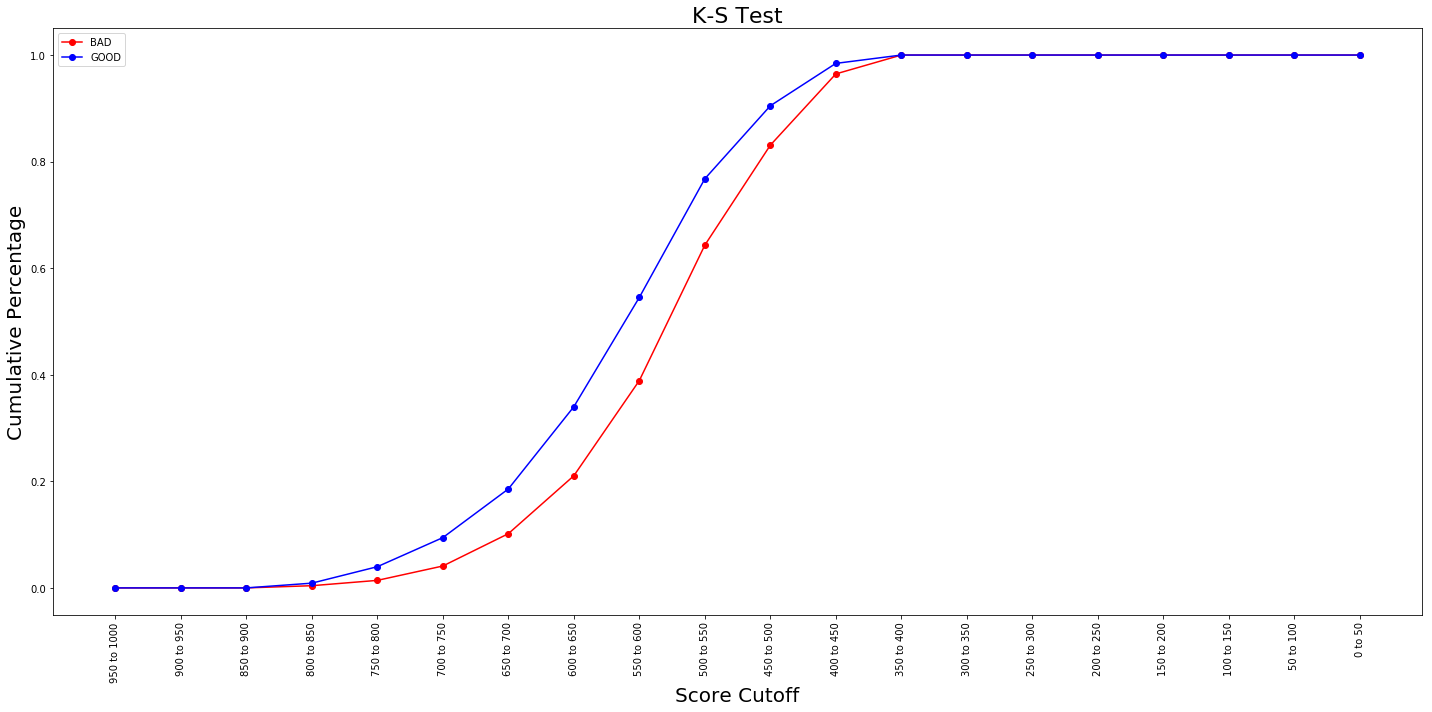

,BAD,GOOD,Cumulative_BAD,Cumulative_GOOD,Cumulative_Percentage_BAD,Cumulative_Percentage_GOOD,Difference,Cumulative_Population_BAD(weighted),Cumulative__Population_GOOD(weighted),Accepted_Cumulated,Acceptance_Percentage_Cumulative(%),Cumulative_Bad_Rate(%)
950 to 1000,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0.00,NaN
900 to 950,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0.00,NaN
850 to 900,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0.00,NaN
800 to 850,19,41,19,41,0.004130,0.008913,0.004783,19,82,101,0.73,18.81
750 to 800,46,142,65,183,0.014130,0.039783,0.025652,65,366,431,3.12,15.08
700 to 750,124,251,189,434,0.041087,0.094348,0.053261,189,868,1057,7.66,17.88
650 to 700,279,420,468,854,0.101739,0.185652,0.083913,468,1708,2176,15.77,21.51
600 to 650,500,710,968,1564,0.210435,0.340000,0.129565,968,3128,4096,29.68,23.63
550 to 600,822,944,1790,2508,0.389130,0.545217,0.156087,1790,5016,6806,49.32,26.30
500 to 550,1169,1024,2959,3532,0.643261,0.767826,0.124565,2959,7064,10023,72.63,29.52


In [121]:
ks_table(cross_tab,weighted_good=2,weighted_bad=1)